# Initial setup

Install `deepxde` and set its backend to `pytorch` (`deepxde` supports a variety of other backends like `tensorflow` or `jax`).

In [ ]:
%%capture
!pip3 install deepxde

In [ ]:
%%capture
!python -m deepxde.backend.set_default_backend pytorch

# Operator learning with DeepONets

In this tutorial we will use [DeepXDE](https://deepxde.readthedocs.io/en/latest/) to showcase a simple instance of operator learning using deep nets.

Our goal will be to learn the antiderivative operator $G : X = L^2([0, 1]) \rightarrow Y = C^1([0, 1])$ for the problem 

$$\frac{du}{dx} = v, \text{ } u(0) = 0$$

i.e. $v \mapsto G(v) = u$.





## What's the actual data like?

Each data point in the dataset is one pair of $(v, u)$, generated as follows:

A random function $v$ is sampled from a Gaussian random field (GRF) with the resolution $m = 100$.
One can then solve for $u$ numerically and get samples at different query points $G(v)(y)$ this way.

We assume that for each $u$, we have the values of $u(x)$ in the same $N_u = 100$ locations. Because we have the values of $u(x)$ in the same locations, we call this dataset as "aligned data".

Notice that this is **not** as general as can be, since in real life there's no guarantee we get samples at the same input locations.

# Learning setup

We will use a typical `DeepOnet` architecture, which takes discretizations of $v$'s along with query points $y \in D(u) $ of $u$ and returns a neural approximation of $G(v)(y)$.

The forward algorithm is rather straight-forward:



*   Discretize input function $v$, i.e. $v \rightarrow v^m := \{v(x_i)\}_{i=1}^m$ for some fixed resolution $m$ and appropriately chosen $x_i$.
*   Discretize the output space $Y$ at some query locations $y$.
*   $v_m \mapsto \text{branch_net}(v_m) =: b = \{b_i\}_{i=1}^p $
*   $y \mapsto \text{trunk_net}(y) =: t = \{t_i\}_{i=1}^p$
*   Set $G(u)(y) := \langle b, t \rangle$


The loss is then taken in the usual $L^2$ sense, such that the predicted $G(u)(y)$ match the reference samples from our dataset.



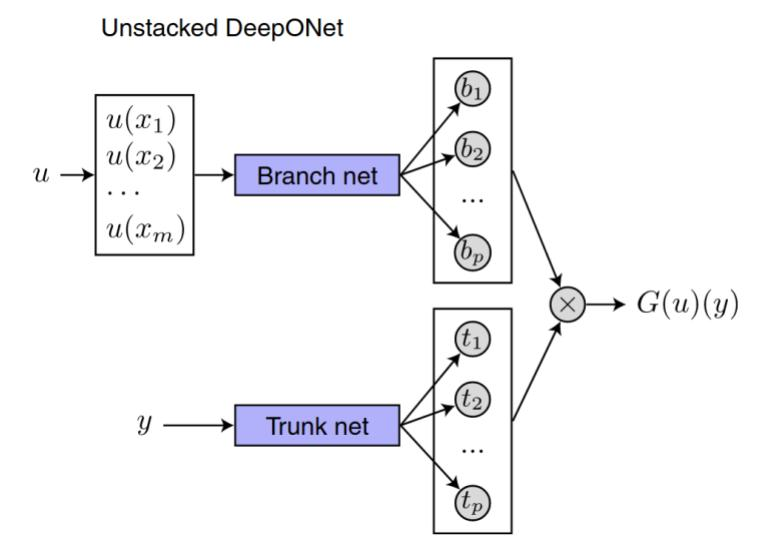

# Building the dataset and training our model

To use `DeepONet`, we need to organize the dataset in the following format:

**Input** of the branch net: the functions $v$
. It is a matrix of shape $(\text{dataset size}, m)$, e.g., $(150, 100)$ for the training dataset.

**Input** of the trunk net: the locations $x$ of $u(x)$ values. It is a matrix of shape $(N_u, \text{dimension})$, i.e., $(100, 1)$ for both training and testing datasets.


**Output**: The values of $u(x)$ in different locations for different $v$. It is a matrix of shape $(\text{dataset size}, N_u)$, e.g., $(150, 100)$ for the training dataset.


We first load the training dataset. The input `X_train` is a tuple; the first element is the branch net input, and the second element is the trunk net input.

In [ ]:
"""Backend supported: tensorflow.compat.v1, tensorflow, pytorch, paddle"""
import deepxde as dde
import matplotlib.pyplot as plt
import numpy as np

Using backend: pytorch
Other supported backends: tensorflow.compat.v1, tensorflow, jax, paddle.
paddle supports more examples now and is recommended.


In [ ]:
# Load dataset.
d = np.load("antiderivative_aligned_train.npz",
            allow_pickle=True)

# Tuple containing branc and trunk net inputs.
X_train = (d["X"][0].astype(np.float32), d["X"][1].astype(np.float32))

# Query locations.
y_train = d["y"].astype(np.float32)
d = np.load("antiderivative_aligned_test.npz",
            allow_pickle=True)

# Same thing, but for testing.
X_test = (d["X"][0].astype(np.float32), d["X"][1].astype(np.float32))
y_test = d["y"].astype(np.float32)

# Data organized as a cartesian product of the inputs.
data = dde.data.TripleCartesianProd(
    X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test
)

In [ ]:
# Always look at the shapes to make sure they're what you'd expect.
X_train[0].shape, X_train[1].shape, y_train.shape

((150, 100), (100, 1), (150, 100))

In [ ]:
# Choose a network. 
m = 100
dim_x = 1
net = dde.nn.DeepONetCartesianProd(
    [m, 40, 40],
    [dim_x, 40, 40],
    "relu",
    "Glorot normal",
)

# Define a Model
model = dde.Model(data, net)

In [ ]:
# Let's peak a bit into what we're actually using here.
# So we see our model's backbone has `branch` and a `trunk` networks 
# as expected. You can also see the sizes of the feature spaces here.
model.net

DeepONetCartesianProd(
  (branch): FNN(
    (linears): ModuleList(
      (0): Linear(in_features=100, out_features=40, bias=True)
      (1): Linear(in_features=40, out_features=40, bias=True)
    )
  )
  (trunk): FNN(
    (linears): ModuleList(
      (0): Linear(in_features=1, out_features=40, bias=True)
      (1): Linear(in_features=40, out_features=40, bias=True)
    )
  )
)

## What happens behind the scenes?

In order to check whether everything makes sense, it's easiest to go directly to the [source](https://deepxde.readthedocs.io/en/latest/_modules/deepxde/nn/pytorch/deeponet.html#DeepONetCartesianProd) code and compare what goes on with our algorithm.

In this case, we see that the `inputs` are split in `2` parts, one for the `branch`, and one for the output `function locations`. They're then passed through the `branch` and `trunk` networks, and summed across the feature dimension as intended.

The summing is done with `einsum` which is a very powerful tool (both computationally and aesthetically), and I encourage you to take a look at a pretty neat [einsum tutorial](https://rockt.github.io/2018/04/30/einsum). 

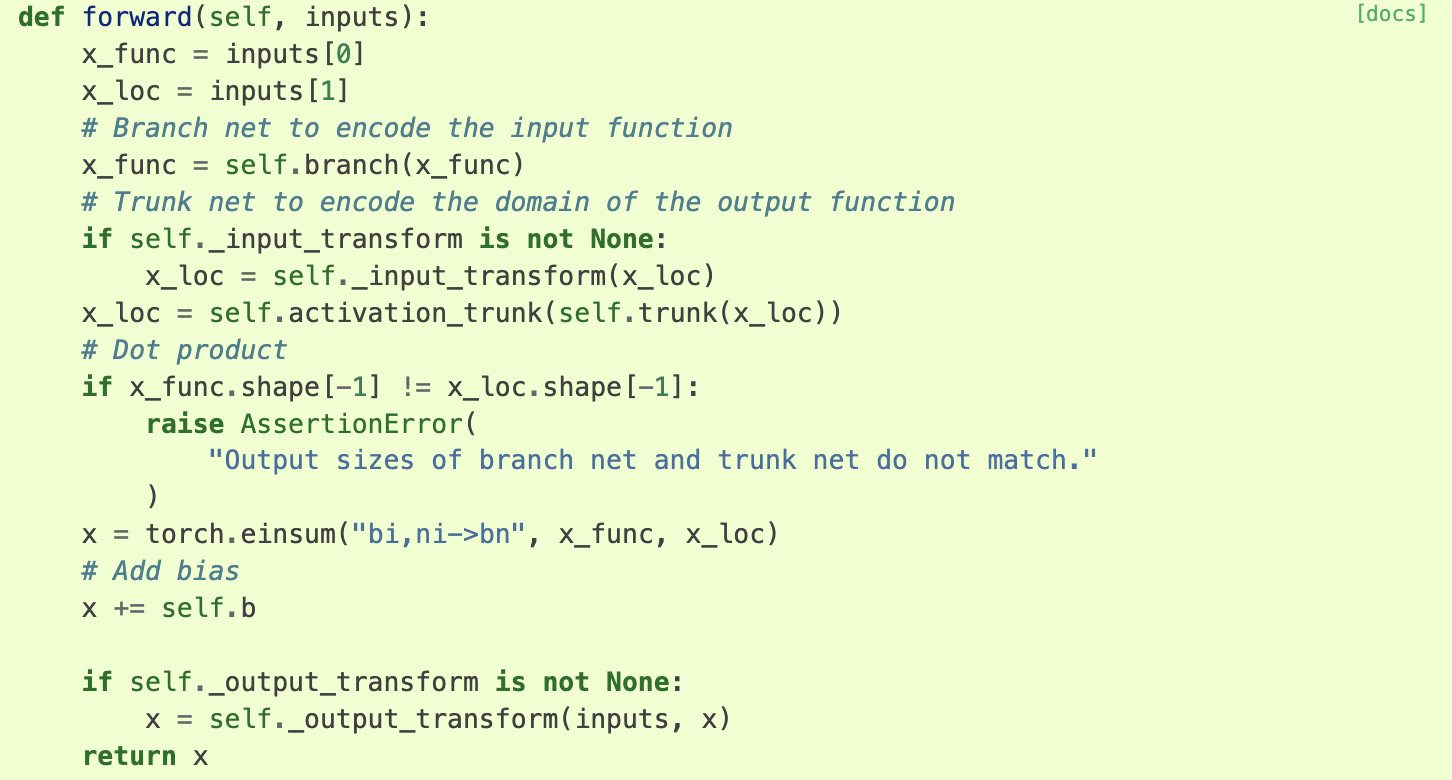

## Training and results


Compiling model...
'compile' took 0.002177 s

Training model...

Step      Train loss    Test loss     Test metric   
10000     [3.87e-05]    [5.21e-05]    [1.93e-02]    
11000     [4.32e-06]    [1.15e-05]    [1.35e-02]    
12000     [4.28e-06]    [1.09e-05]    [1.32e-02]    
13000     [4.07e-06]    [1.03e-05]    [1.27e-02]    
14000     [4.85e-06]    [1.05e-05]    [1.26e-02]    
15000     [1.82e-05]    [2.75e-05]    [1.76e-02]    
16000     [3.11e-05]    [3.28e-05]    [1.64e-02]    
17000     [3.00e-06]    [8.78e-06]    [1.19e-02]    
18000     [2.93e-06]    [8.52e-06]    [1.16e-02]    
19000     [5.33e-06]    [1.12e-05]    [1.26e-02]    
20000     [2.70e-06]    [8.13e-06]    [1.14e-02]    

Best model at step 20000:
  train loss: 2.70e-06
  test loss: 8.13e-06
  test metric: [1.14e-02]

'train' took 26.031736 s



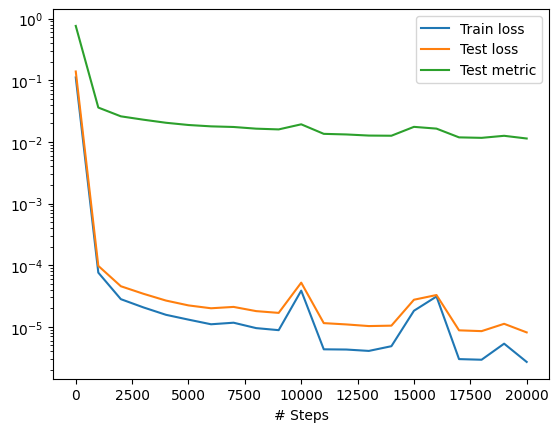

In [ ]:
# Compile and train.
model.compile("adam", lr=0.001, metrics=["mean l2 relative error"])
losshistory, train_state = model.train(iterations=10000)

# Plot the loss trajectory
dde.utils.plot_loss_history(losshistory)
plt.show()